In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import community  # Instalar con 'pip install python-louvain'

In [2]:
df = pd.read_csv('criptomonedasv2.csv')
# Crear una nueva columna que indica si tiene suministro máximo
df['Tiene_suministro_maximo'] = df['Suministro máximo'].notnull().astype(int)
# Reemplazar valores nulos por un número alto para representar suministro ilimitado
df['Suministro máximo'].fillna(np.inf, inplace=True)
variables = ['Valor USD', 'Capitalizacion de mercado', 'Volumen en 24h',
             'Porcentaje del volumen diario', 'Suministro circulante', 'Tiene_suministro_maximo']
# Filtrar las filas sin datos faltantes en las variables seleccionadas
df_clean = df.dropna(subset=variables)
# Normalizar las variables
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[variables])
# Calcular la matriz de similitud
similaridad = cosine_similarity(X)

C:\Users\renat\AppData\Local\Temp\ipykernel_16180\1183971863.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Suministro máximo'].fillna(np.inf, inplace=True)


In [3]:
k = 5  # Define el número de vecinos más cercanos

# Crear un grafo vacío
G_knn = nx.Graph()

# Añadir los nodos con sus atributos
for index, row in df_clean.iterrows():
    G_knn.add_node(row['Nombre'], **row.to_dict())

# Añadir las aristas basadas en los k vecinos más cercanos
for i in range(len(df_clean)):
    # Obtener los índices de los k vecinos más cercanos (excluyendo el mismo nodo)
    indices_vecinos = np.argsort(-similaridad[i])[1:k+1]
    for j in indices_vecinos:
        G_knn.add_edge(df_clean.iloc[i]['Nombre'], df_clean.iloc[j]['Nombre'], weight=similaridad[i][j])


In [4]:
# Detectar comunidades
partition = community.best_partition(G_knn)

# Añadir la comunidad como atributo de los nodos
nx.set_node_attributes(G_knn, partition, 'comunidad')

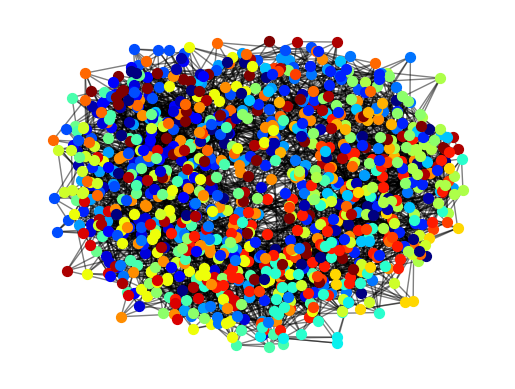

In [5]:
# Posición de los nodos
pos = nx.spring_layout(G_knn, k=0.15, iterations=20)

# Extraer las comunidades
comunidades = set(partition.values())

# Asignar colores a las comunidades
colors = plt.cm.jet(np.linspace(0, 1, len(comunidades)))
color_map = {}
for comunidad, color in zip(comunidades, colors):
    color_map[comunidad] = color

# Dibujar los nodos con colores según la comunidad
for nodo in G_knn.nodes():
    nx.draw_networkx_nodes(G_knn, pos, [nodo], node_size=50, node_color=[color_map[partition[nodo]]])

# Dibujar las aristas
nx.draw_networkx_edges(G_knn, pos, alpha=0.5)

plt.axis('off')
plt.show()